In [15]:
import pandas as pd
import seaborn as sns
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score,confusion_matrix, roc_curve, auc, silhouette_score, recall_score, precision_score,roc_auc_score, precision_recall_curve, f1_score,plot_confusion_matrix
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import pickle

In [2]:
data = pd.read_csv('fake_or_real_cleaned.csv')

In [3]:
class TextTransformer(BaseEstimator, TransformerMixin):
    '''
    Custom transformer que limpia el texto de caracteres especiales, quita stopwords y aplica lemmatizer
    '''
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.str.lower().str.strip()
        translator = str.maketrans('', '', string.punctuation+'’‘—“”–')
        X = X.map(lambda x: x.strip().lower().translate(translator))
        stopwords = nltk.corpus.stopwords.words('english')
        wordnet_lemmatizer = WordNetLemmatizer()
        X = X.map(word_tokenize).apply(lambda x: [word for word in x if word not in stopwords])
        X = X.apply(lambda x: [wordnet_lemmatizer.lemmatize(w, pos="v") for w in x])
        X = X.apply(lambda x: ' '.join(x)).to_numpy()
        return X

In [4]:
pipeline = Pipeline([
    ("text", TextTransformer()),
    ("tfidf", TfidfVectorizer()),
    ("clf", PassiveAggressiveClassifier())
])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data['text'],data['label'], random_state=0)

In [6]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('text', TextTransformer()), ('tfidf', TfidfVectorizer()),
                ('clf', PassiveAggressiveClassifier())])

In [7]:
pipeline.score(X_test,y_test)

0.9201014584654407

In [8]:
parameters = {
    "tfidf__max_df": (0.5, 0.75, 1.0),
    "tfidf__max_features": (None, 5000, 10000, 50000),
    "tfidf__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "tfidf__use_idf": (True, False),
    "tfidf__norm": ('l1', 'l2'),
    "clf__C": (1.0,1.5,2.0,),
    "clf__max_iter": (500,1000, 2000),
    "clf__early_stopping": (True,False)
}

cv = RandomizedSearchCV(pipeline, parameters, n_jobs=-1, verbose=1,n_iter=35)
cv.fit(X_train, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('text', TextTransformer()),
                                             ('tfidf', TfidfVectorizer()),
                                             ('clf',
                                              PassiveAggressiveClassifier())]),
                   n_iter=35, n_jobs=-1,
                   param_distributions={'clf__C': (1.0, 1.5, 2.0),
                                        'clf__early_stopping': (True, False),
                                        'clf__max_iter': (500, 1000, 2000),
                                        'tfidf__max_df': (0.5, 0.75, 1.0),
                                        'tfidf__max_features': (None, 5000,
                                                                10000, 50000),
                                        'tfidf__ngram_range': ((1, 1), (1, 2)),
                                        'tfidf__norm': ('l1', 'l2'),
                                        'tfidf__use_idf': (True, False)},
   

In [9]:
cv.best_estimator_.get_params()

{'memory': None,
 'steps': [('text', TextTransformer()),
  ('tfidf',
   TfidfVectorizer(max_df=0.75, max_features=50000, ngram_range=(1, 2))),
  ('clf',
   PassiveAggressiveClassifier(C=1.5, early_stopping=True, max_iter=500))],
 'verbose': False,
 'text': TextTransformer(),
 'tfidf': TfidfVectorizer(max_df=0.75, max_features=50000, ngram_range=(1, 2)),
 'clf': PassiveAggressiveClassifier(C=1.5, early_stopping=True, max_iter=500),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 0.75,
 'tfidf__max_features': 50000,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use

Metricas

In [11]:
print(f'Accuracy: {cv.score(X_test,y_test)}')

Accuracy: 0.9213696892834495


In [12]:
predictions = cv.predict(X_test)

In [13]:
print(f'Precision: {precision_score(y_test,predictions)}')
print(f'Recall: {recall_score(y_test,predictions)}')
print(f'F1: {f1_score(y_test,predictions)}')

Precision: 0.9230769230769231
Recall: 0.9207547169811321
F1: 0.9219143576826198


Matriz de confusion

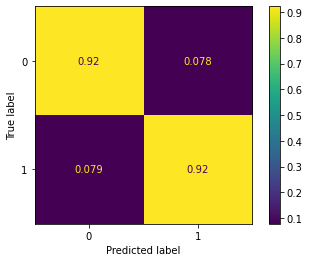

In [16]:
ConfusionMatrixDisplay.from_predictions(y_test, predictions,normalize='true')

Guardar modelo

In [17]:
pickle.dump(cv.best_estimator_, open('pipeline', 'wb'))